FOG 事件的長度範圍為 0.5 至 40.5 s（平均 7.3 s [SD 6.7 s]）。50% 的 FOG 發作持續時間少於 5.4 秒，大多數（93.2%）的時間少於 20 秒（見圖6）。這些結果類似於早期的 FOG 持續時間表徵[8]。


In [1]:
import pandas as pd
import numpy as np

import os

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import LSTM, TimeDistributed, ConvLSTM2D

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score
from keras import backend as k

In [2]:
train_data_path = os.getcwd() + "/dataset/total_train.csv"
test_data_path = os.getcwd() + "/dataset/total_test.csv"
# features = ["A_F", "A_V", "A_L", "L_F", "L_T", "L_L", "T_F", "T_V", "T_L"]

train_dataset = pd.read_csv(train_data_path)
train_time = list(train_dataset['time'])
train_dataframe = train_dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L"]].values
train_dataset = train_dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L", "Action"]].values

window_length = int(1*64)
train_total_windows = int((len(train_dataset))/window_length)

In [3]:
test_patients = ["S01", "S02"]

test_dataset = pd.read_csv(test_data_path)
test_time = list(test_dataset['time'])
test_dataframe = test_dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L"]].values
test_dataset = test_dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L", "Action"]].values

test_total_windows = int((len(test_dataset))/window_length)

In [4]:
train_dataframe = (train_dataframe-train_dataframe.mean())/(train_dataframe.std())
test_dataframe = (test_dataframe-test_dataframe.mean())/(test_dataframe.std())

確認每段資料能不能整除64/2, 並輸出不能整除的個數

In [5]:
indices = train_time
groups = []
group_count = 0
temp = []
lenOfGroup = []
length_count = 0

for i in range(len(indices)):
    if i == (len(indices) - 1):
        temp.append(indices[i])
        length_count = length_count + 1

        groups.append(temp)
        lenOfGroup.append(length_count)
        length_count = 0
        temp = []
        break
    temp.append(indices[i])
    length_count = length_count + 1
    if (indices[i+1] - 20 > indices[i]):
        group_count = group_count + 1

        lenOfGroup.append(length_count)
        length_count = 0

        groups.append(temp)
        temp = []

del temp, indices, group_count, length_count, i

countOfUndivisible = 0
total_windows_with_overlap_train = 0

start_index = 0

stop_Indexs = []
stop_Index = -window_length


for lengths in lenOfGroup:
    stop_Index = stop_Index + lengths
    stop_Indexs.append(stop_Index)
    total_windows_with_overlap_train = total_windows_with_overlap_train + int(float(lengths/window_length)*2 -1)
    
    if lengths % (window_length/2) != 0:
        countOfUndivisible = countOfUndivisible + 1
        print(lengths)

print(countOfUndivisible)
del countOfUndivisible, lengths

0


In [6]:
X = np.empty((total_windows_with_overlap_train, window_length*9))
y = np.empty((total_windows_with_overlap_train, 1))

stop_Index = 0
window_count = 0

for window in range(total_windows_with_overlap_train):
    for i in range(window_length):
        if i == 0:
            y[window] = train_dataset[int(window_count*window_length), 9]
        
        if int(window_count*window_length)<len(train_dataset)-window_length-1:
            for data in range(9):
               X[window, i*9 + data] = train_dataframe[int(window_count*window_length) + i, data]
        if stop_Index < len(stop_Indexs):
            if int(window_count*window_length) == stop_Indexs[stop_Index]:
                window_count = window_count + 0.5
                stop_Index = stop_Index + 1
        if window == total_windows_with_overlap_train-1:
            X[window, i*9 + data] = train_dataframe[int((window_count-0.5)*window_length) + i, data]
    window_count = window_count + 0.5

In [7]:
indices = test_time
groups = []
group_count = 0
temp = []
lenOfGroup = []
length_count = 0

for i in range(len(indices)):
    if i == (len(indices) - 1):
        temp.append(indices[i])
        length_count = length_count + 1

        groups.append(temp)
        lenOfGroup.append(length_count)
        length_count = 0
        temp = []
        break
    temp.append(indices[i])
    length_count = length_count + 1
    if (indices[i+1] - 20 > indices[i]):
        group_count = group_count + 1

        lenOfGroup.append(length_count)
        length_count = 0

        groups.append(temp)
        temp = []

del temp, indices, group_count, length_count, i

countOfUndivisible = 0
total_windows_with_overlap_test = 0

start_index = 0

stop_Indexs = []
stop_Index = -window_length


for lengths in lenOfGroup:
    stop_Index = stop_Index + lengths
    stop_Indexs.append(stop_Index)
    total_windows_with_overlap_test = total_windows_with_overlap_test + int(float(lengths/window_length)*2 -1)
    
    if lengths % (window_length/2) != 0:
        countOfUndivisible = countOfUndivisible + 1
        print(lengths)

print(countOfUndivisible)
del countOfUndivisible, lengths

0


In [8]:
X_test = np.empty((total_windows_with_overlap_test, window_length*9))
y_test = np.empty((total_windows_with_overlap_test, 1))

stop_Index = 0
window_count = 0

for window in range(total_windows_with_overlap_test):
    for i in range(window_length):
        if i == 0:
            y_test[window] = test_dataset[int(window_count*window_length), 9]
        
        if int(window_count*window_length)<len(test_dataset)-window_length-1:
            for data in range(9):
               X_test[window, i*9 + data] = test_dataframe[int(window_count*window_length) + i, data]
        if stop_Index < len(stop_Indexs):
            if int(window_count*window_length) == stop_Indexs[stop_Index]:
                window_count = window_count + 0.5
                stop_Index = stop_Index + 1
        if window == total_windows_with_overlap_test-1:
            X_test[window, i*9 + data] = test_dataframe[int((window_count-0.5)*window_length) + i, data]
    window_count = window_count + 0.5

In [9]:
from sklearn.model_selection import StratifiedKFold

In [10]:
unique, counts = np.unique(y, return_counts=True)

class_weight = {0:(1/counts[0])*len(y)/2, 1:(1/counts[1])*len(y)/2, 2:(1/counts[2])*len(y)/2}

In [11]:
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state=42)
skf.get_n_splits(X, y)
print(skf)

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


In [12]:
def to_3Darray(array):
    arr_3d = np.empty((len(array), window_length, 9))


    arr_3d = np.reshape(array, (len(array), window_length, 9))
    return arr_3d

In [13]:
scores = list()

In [14]:
scores_in_fold = []
losses = []

In [15]:
scores_outside_fold = []

In [16]:
for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    print("==> Fold #%d" % i)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = to_3Darray(X_train)
    y_train = to_categorical(y_train)

    X_val = to_3Darray(X_val)
    y_val = to_categorical(y_val)


    
    verbose, epochs, batch_size = 0, 50, 64
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

    n_steps, n_length = 2, 32
    X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
    X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))


    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'),
                            input_shape=(None, n_length, n_features)))
    model.add(TimeDistributed(
        Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    hunderdOutput = Dense(100, activation='relu')
    model.add(hunderdOutput)  # feature
    # 試著輸出長度為100的向量(feature) 並絳維 看他的分布有無分開
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) #可能可以調weighting
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight = class_weight)
    
    loss, accuracy = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
    

    y_pred = (model.predict(X_val) > 0.5).astype("int32")
    y_val = np.argmax(y_val, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    confus = confusion_matrix(y_val, y_pred, labels=None, sample_weight=None)
    tp = confus[1][1]
    tn = confus[0][0] + confus[0][2] + confus[2][0] + confus[2][2]
    fp = confus[1][0] + confus[1][2]
    fn = confus[0][1] + confus[2][1]

    precision = (tp/(tp + fp))*100
    sensitivity =  (tp / (tp + fn))*100   #sensitivity
    specificity = (tn/(tn + fp))*100
    F1_score = ((2*tp) / (2*tp + fp + fn))*100

    score = accuracy
    losses.append(loss)
    
    score = score * 100.0
    scores_in_fold.append(score)
    
    print('Loss: %.3f%% Accuracy: %.3f%% ' % (loss, score))
    print('specificity: %.3f%% sensitivity: %.3f%% F1 score: %.3f%%' % (specificity, sensitivity, F1_score))
    # print(confus)


    
    '''score = evaluate_model(X_train, y_train, X_val, y_val)
    score = score * 100.0
    print(score)
    scores.append(score)'''

    

==> Fold #0
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Loss: 0.214% Accuracy: 91.895% 
specificity: 99.096% sensitivity: 48.105% F1 score: 62.382%
==> Fold #1
Loss: 0.220% Accuracy: 91.520% 
specificity: 99.136% sensitivity: 47.564% F1 score: 62.056%
==> Fold #2
Loss: 0.184% Accuracy: 93.208% 
specificity: 99.149% sensitivity: 52.532% F1 score: 66.135%
==> Fold #3
Loss: 0.235% Accuracy: 91.820% 
specificity: 99.221% sensitivity: 47.458% F1 score: 62.222%
==> Fold #4
Loss: 0.225% Accuracy: 91.895% 
specificity: 99.394% sensitivity: 48.451% F1 score: 63.586%
==> Fold #5
Loss: 0.199% Accuracy: 92.908% 
specificity: 99.020% sensitivity: 51.258% F1 score: 64.683%
==> Fold #6
Loss: 0.248% Accuracy: 90.578% 
specificity: 99.382% sensitivity: 43.577% F1 score: 59.247%
==> Fold #7
Loss: 0.141% Accuracy: 95.345% 
specificity: 98.842% sensitivity: 64.898% F1 score: 73.611%
==> Fold #8
Loss: 0.156% Accur

In [17]:
layerIndex = 7
func = k.function([model.get_layer(index=0).input], model.get_layer(index=layerIndex).output)
layerOutput = func([X_val])

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(layerOutput)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
y_val = pd.DataFrame(data = y_val, columns=['targets'])

In [19]:
finalDF = pd.concat([principalDf, y_val], axis=1, ignore_index=True)

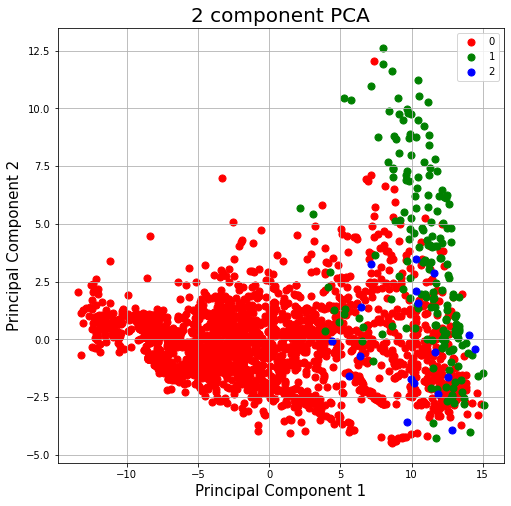

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDF[2] == target
    ax.scatter(finalDF.loc[indicesToKeep, 0]
               , finalDF.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [21]:
m, s = np.mean(scores_in_fold), np.std(scores_in_fold)
print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

Accuracy: 92.907% (+/-1.581)


In [22]:
X_test = to_3Darray(X_test)
#y_test = to_categorical(y_test)
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))


# loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)


In [23]:
y_test = to_categorical(y_test)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

confus = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)

In [24]:
print(confus)

[[5452  292   28]
 [ 952  506   27]
 [ 138   55    5]]


In [25]:
tp = confus[1][1]
tn = confus[0][0] + confus[0][2] + confus[2][0] + confus[2][2]
fp = confus[1][0] + confus[1][2]
fn = confus[0][1] + confus[2][1]

precision = (tp/(tp + fp))*100
sensitivity = (tp / (tp + fn))*100  # sensitivity
specificity = (tn/(tn + fp))*100
F1_score = ((2*tp) / (2*tp + fp + fn))*100


In [26]:
accuracy = accuracy_score(y_test, y_pred)*100

In [27]:
accuracy = accuracy
print('Accuracy: %.3f%% ' % (accuracy))
print('FOG: specificity: %.3f%% sensitivity: %.3f%% F1 score: %.3f%%' % (specificity, sensitivity, F1_score))

Accuracy: 79.987% 
FOG: specificity: 85.171% sensitivity: 59.320% F1 score: 43.285%


In [28]:
tp = confus[2][2]
tn = confus[0][0] + confus[0][1] + confus[1][0] + confus[1][1]
fp = confus[2][0] + confus[2][1]
fn = confus[0][2] + confus[1][2]

precision = (tp/(tp + fp))*100
sensitivity = (tp / (tp + fn))*100  # sensitivity
specificity = (tn/(tn + fp))*100
F1_score = ((2*tp) / (2*tp + fp + fn))*100
print('PreFOG: specificity: %.3f%% sensitivity: %.3f%% F1 score: %.3f%%' % (specificity, sensitivity, F1_score))

PreFOG: specificity: 97.390% sensitivity: 8.333% F1 score: 3.876%


In [29]:
from keras.models import load_model

In [30]:
model.save('my_model.h5')